## Task 1: Naive Compositing (10 pts)
Implement a function naiveComposite(bg, fg, mask, y, x) that simply copies the pixel values from an image fg into a target bg when mask is equal to 1. fg is assumed to be smaller than bg and has the same size as mask. y and x specify where the upper left corner of fg goes in the source image
bg.

In [1]:
from IPython.display import Image
import numpy as np
import cv2
from lib.display_helper import *

def naive_composite(bg, fg, mask, y, x):
    bmask = mask.astype(np.bool)
    output = bg.copy()
    (fh,fw,fc) = fg.shape
    output[y:y+fh,x:x+fw][bmask] = fg[bmask]
    return output

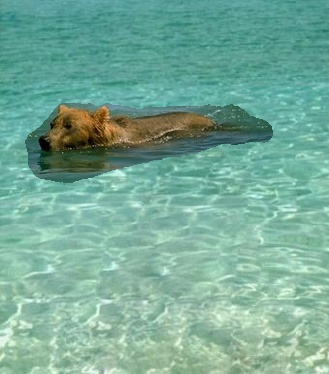

In [2]:
bg_img = cv2.imread('data/waterpool.png')
fg_img = cv2.imread('data/bear.png')
mask_img = cv2.imread('data/mask.png')

output = naive_composite(bg_img, fg_img, mask_img, 50, 0)
output_path = 'output/naive.jpg'
cv2.imwrite(output_path, output)

Image(output_path)

## Task 2: Poisson Gradient Descent (40)
Write a function Poisson(bg, fg, mask, niter) implements gradient descent to solve for Poisson image compositing. bg, fg, and mask are assumed to have the same size.

Implement a Laplacian operator and a dot product for images functions. 

Test this function on the small inputs because it is slow to converge. I highly recommend the provided testRamp which seeks to paste a flat source into a background composed of a greyscale ramp. Input and in the first row, and x0, x50, x100, x200.

In [3]:
from scipy.ndimage.filters import laplace
from scipy.signal import convolve2d

def laplacian(img):
    l_operator = np.array([[0., -1., 0. ],[-1. , 4., -1.],[0., -1., 0.]], np.float64)
    out = np.zeros_like(img)
    for c in range(img.shape[2]):
        out[...,c] = convolve2d(img[...,c], l_operator, mode='same')
    return out
    
def poisson_gdesc(bg, fg, mask, max_it):
    if not (bg.shape == fg.shape and fg.shape == mask.shape):
        raise NotImplementedError("Implemented only for equal shapes")
        
    bmask = mask.astype(np.bool)
    # buggy line: b = laplacian(fg).astype(np.float64)*bmask
    b = laplacian(fg.astype(np.float64))*bmask
    x = bg.astype(np.float64)
    x[bmask] = 0.0
    for iteration in range(max_it):
        Ax = laplacian(x)
        r = (b - Ax) * bmask
        r_flat = r.flatten()
        Ar_flat = laplacian(r).flatten()
        alpha = np.dot(r_flat, r_flat) / np.dot(r_flat, Ar_flat)
        x = x + (r*bmask) * alpha
        
    return x.clip(0,255).astype(bg.dtype)

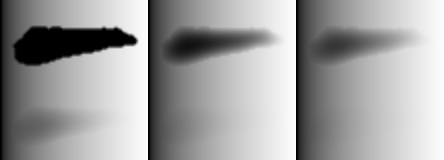

In [4]:
bg = cv2.imread('data/ramp.png')
fg = cv2.imread('data/fg.png')
mask = cv2.imread('data/mask3.png')


outputs = []
outputs.append([
        cv2.resize(poisson_gdesc(bg, fg, mask, 1),(148,80)),
        cv2.resize(poisson_gdesc(bg, fg, mask, 50),(148,80)),
        cv2.resize(poisson_gdesc(bg, fg, mask, 100),(148,80))])
outputs.append([
        cv2.resize(poisson_gdesc(bg, fg, mask, 200),(148,80)),
        cv2.resize(poisson_gdesc(bg, fg, mask, 400),(148,80)),
        cv2.resize(poisson_gdesc(bg, fg, mask, 800),(148,80))])

output_path = 'output/poisson_GDesc_ramp.jpg'
cv2.imwrite(output_path, multiple_display(outputs))

Image(output_path)

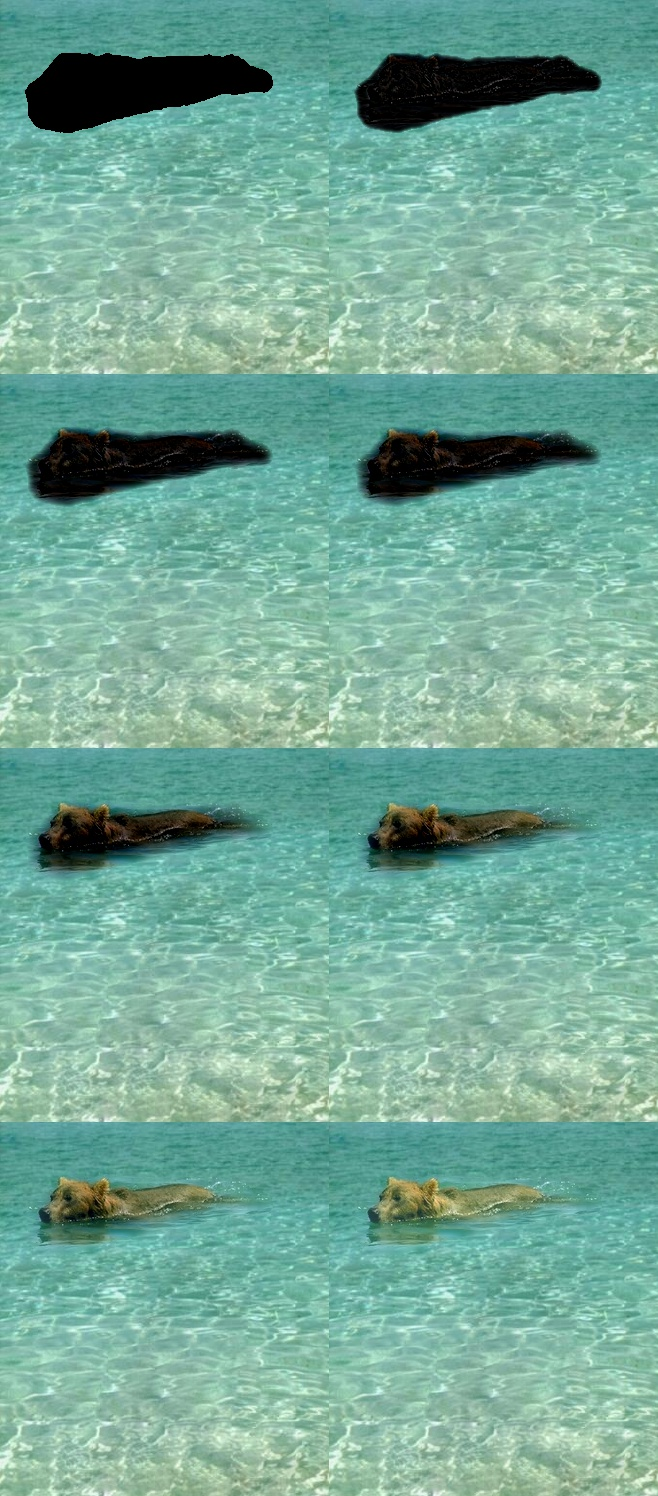

In [5]:
bg = cv2.imread('data/waterpool.png')
_fg = cv2.imread('data/bear.png')
_mask = cv2.imread('data/mask.png')

fg = np.zeros_like(bg)
mask = np.zeros_like(bg)

fg[:_fg.shape[0],:_fg.shape[1]] = _fg
mask[:_mask.shape[0],:_mask.shape[1]] = _mask

outputs = []
outputs.append([poisson_gdesc(bg, fg, mask, 0), poisson_gdesc(bg, fg, mask, 10)])
outputs.append([poisson_gdesc(bg, fg, mask, 50), poisson_gdesc(bg, fg, mask, 100)])
outputs.append([poisson_gdesc(bg, fg, mask, 400), poisson_gdesc(bg, fg, mask, 800)])
outputs.append([poisson_gdesc(bg, fg, mask, 2000), poisson_gdesc(bg, fg, mask, 8000)])

output_path = 'output/poisson_GDesc_bear.jpg'
cv2.imwrite(output_path, multiple_display(outputs))

Image(output_path)

## Task 3: Poisson Conjugate (50)

Write a function PoissonCG(bg, fg, mask, niter) that implements the above conjugate gradient algorithm to solve Poisson image editing. The specifications are the same as for gradient descent.

Similarly, $x_0$ , $r_i$ and $d_i$ need to be masked appropriately. Note how much faster the conjugate
method converges.

In [6]:
def poisson_conj(bg, fg, mask, max_it):
    if not (bg.shape == fg.shape and fg.shape == mask.shape):
        raise NotImplementedError("Implemented only for equal shapes")
        
    bmask = mask.astype(np.bool)
    
    b = laplacian(fg.astype(np.float64)) * bmask
    x = bg.astype(np.float64)
    x[bmask] = 0.0
    Ax = laplacian(x) * bmask
    r = b - Ax
    d = r.copy()
    for iteration in range(max_it):
        Ad = laplacian(d) * bmask
        r_dot = np.dot(r.flatten(), r.flatten())
        alpha = r_dot / np.dot(d.flatten(), Ad.flatten())
        x += d*bmask*alpha
        
        r_new = (r-alpha*Ad) * bmask
        
        beta = np.dot(r_new.flatten(), r_new.flatten()) / r_dot
        d = (r_new + beta*d) * bmask
        r = r_new
        
        
    return x.clip(0,255).astype(bg.dtype)

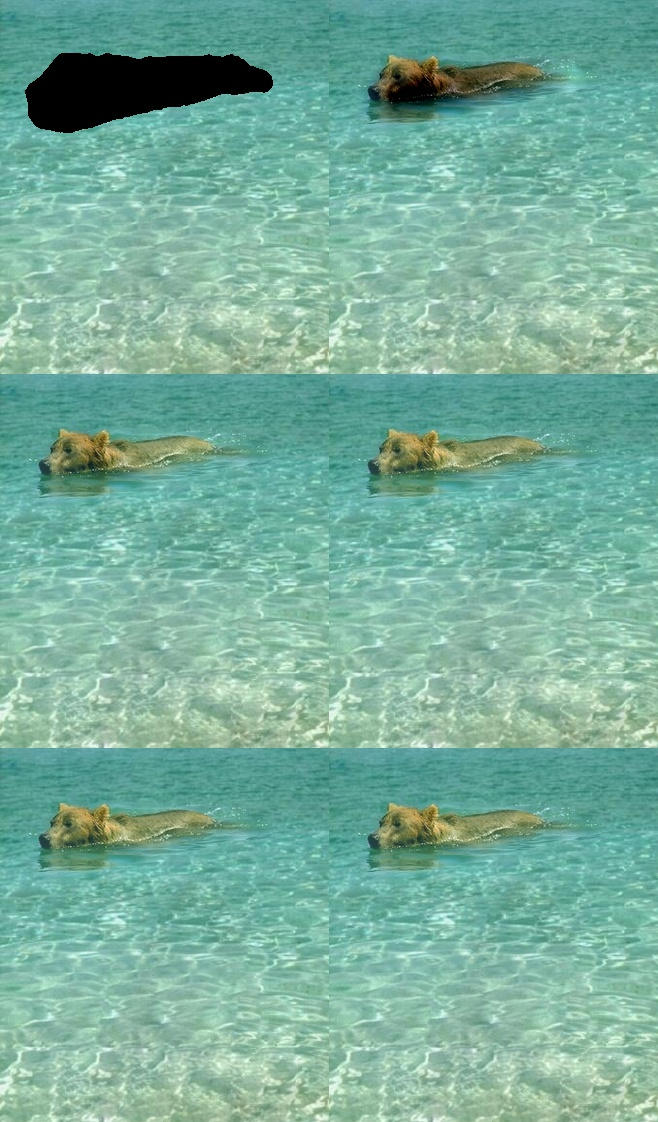

In [7]:
bg = cv2.imread('data/waterpool.png')
_fg = cv2.imread('data/bear.png')
fg = np.zeros_like(bg)
fg[:_fg.shape[0],:_fg.shape[1]] = _fg
_mask = cv2.imread('data/mask.png')
mask = np.zeros_like(bg)
mask[:_mask.shape[0],:_mask.shape[1]] = _mask


outputs = []
outputs.append([poisson_conj(bg, fg, mask, 0), poisson_conj(bg, fg, mask, 50)])
outputs.append([poisson_conj(bg, fg, mask, 100), poisson_conj(bg, fg, mask, 200)])
outputs.append([poisson_conj(bg, fg, mask, 1000), poisson_conj(bg, fg, mask, 2000)])

output_path = 'output/poisson_GConj_bear.jpg'
cv2.imwrite(output_path, multiple_display(outputs))

Image(output_path)

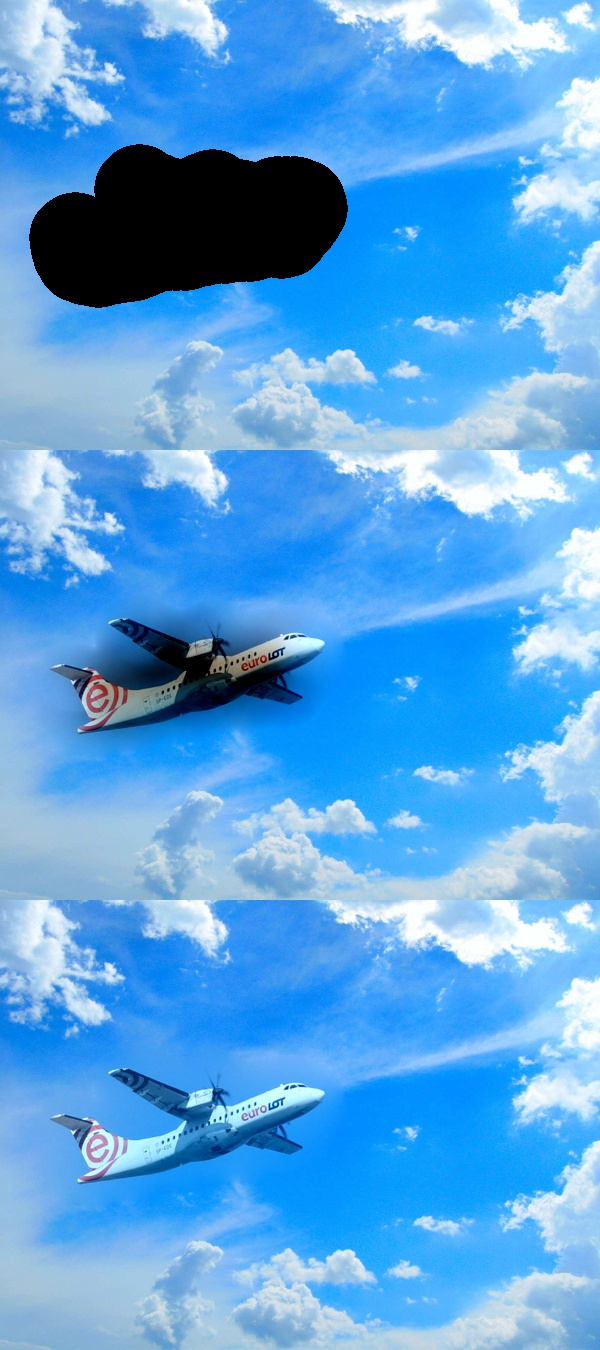

In [8]:
bg = cv2.imread('data/sky_bg.png')
fg = cv2.imread('data/sky_fg.png')
mask = cv2.imread('data/sky_mask.png')


outputs = []
outputs.append([poisson_conj(bg, fg, mask, 0)])
outputs.append([poisson_conj(bg, fg, mask, 100)])
outputs.append([poisson_conj(bg, fg, mask, 500)])

output_path = 'output/poisson_GConj_sky.jpg'
cv2.imwrite(output_path, multiple_display(outputs))

Image(output_path)